In [203]:
import pandas as pd
import os
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List
from wordcloud import WordCloud, STOPWORDS
import spacy

%matplotlib inline
sns.set(style="darkgrid")


In [15]:
data_dir = '../data'

oilspills_csvpath = os.path.join(data_dir, 'US_oilspills.csv')

### Loading Data

Initial findings from loading data:
-  3710 rows of data, each has an ID, open_date, name, lat and lon. 
-  We drop all the columns with all NaN values as these contain no useful information
-  We also drop the row of index '8039' as this is the only one with data inside the other 'field' columns (12/13/14/15/24/25 with 1 non-null value each) and is an outlier. This may infact contain useful information however we are unsure what to do with it and want to visualise the bulk of our data with a simple version 1 right now. This could be a future endeavour
-  It is unsure what field_10 represents, this could be important and a future task could be to include it. However, for now we remove it as it has no meaning right now.
-  It looks like field_11 contains furthe information. So we will rename the column as such.

So we create a function to load and format our data with the above points in mind.
We would be left with columns:
-  id
-  open_date: YYYY-DD-MM ex. 2020-02-27, granularity of days
-  name 
-  location: String Description of location
-  lat
-  lon
-  threat: Oil/Chemical/Other
-  commodity
-  max_ptl_release_gallons: Floating Value
-  description

In [5]:
def load_oilspills(csvpath: str) -> pd.DataFrame:
    
    oilspills = pd.read_csv(csvpath, 
                            index_col='id', 
                            parse_dates=['open_date'])

    # remove anomalous row (contains additional fields in columns)
    row_8039 = oilspills[oilspills['field_12'].notna()]
    oilspills = oilspills.drop(row_8039.index)

    # drop columns with NaN values
    oilspills = oilspills.dropna(axis=1, how='all')

    # drop column: 'field_10'
    oilspills = oilspills.drop(['field_10'], axis=1)

    oilspills = oilspills.rename(columns={'field_11':'description'})
    
    return oilspills


In [14]:
oilspills = load_oilspills(oilspills_csvpath)
oilspills.head()

,open_date,name,location,lat,lon,threat,commodity,max_ptl_release_gallons,description
id,,,,,,,,,
10049,2020-02-27,Partially Submerged Recreational Vessel Huron ...,"Huron, OH",41.391532,-82.554591,Oil,NaN,NaN,"On February 27, 2020, SSC received notificatio..."
10050,2020-02-27,Whitney Tank Battery 160 Loomis Pass Spill,"Venice, LA, USA",29.116625,-89.180917,Oil,NaN,NaN,"On February 27, 2020, the USCG Sector New Orle..."
10048,2020-02-24,Gray whale carcass,"Port Hueneme, CA",34.149744,-119.208226,Other,NaN,NaN,"On 24-FEB-2020, NMFS Stranding Coordinator in ..."
10047,2020-02-20,Recreational vessel sunk in Anacortes Skyline ...,"2400 Skyline Way, Anacortes, WA 98221, USA",48.492559,-122.680368,Oil,NaN,NaN,"On February 20, 2020, the SEA WOLF, a 44 foot ..."
10046,2020-02-17,North Santiam River - Truck Spill,"N Santiam Hwy, Detroit, OR 97342, USA",44.697000,-122.226890,Oil,NaN,NaN,On the morning of 16 FEB 2020 along the Santi...


In [140]:
oilspills.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3709 entries, 10049 to 6200
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   open_date                3709 non-null   datetime64[ns]
 1   name                     3709 non-null   object        
 2   location                 3707 non-null   object        
 3   lat                      3709 non-null   float64       
 4   lon                      3709 non-null   float64       
 5   threat                   2413 non-null   object        
 6   commodity                3101 non-null   object        
 7   max_ptl_release_gallons  2074 non-null   float64       
 8   description              1776 non-null   object        
 9   year                     3709 non-null   int64         
 10  month                    3709 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 507.7+ KB


With that, we can try to discover more about our dataset through visualiastions.

In [22]:
earliest_incident_date = min(oilspills['open_date'])
latest_incident_date = max(oilspills['open_date'])

print(f"Earliest Incident Occurred on: {earliest_incident_date}")
print(f"Latest Incident Occurred on: {latest_incident_date}")

Earliest Incident Occurred on: 1957-03-29 00:00:00
Latest Incident Occurred on: 2020-11-02 00:00:00


## Initial Exploration of Data with Simple Non-Interactive Plots
### Investigating Threats and Potential Release Quantity

Findings that emerge:
-  Oilspills are the most common threat type
-  The number of oilspills spiked aorund 1985 and afte 2002/2003. Before this, the number of oilspills were very sparse. This can also be said for other threat types (chemical and other). Here we could also question how our data was collected for possible explanations for this phenomena
-  Total number of incidents does not appear to vary too widely depending on month by visual observation. Largest difference is between month 7 and 2 (July and February respectively) with a peak value around 190 and a minimum value nearing 150 counts for oil threats
-  The biggest max_ptl_release_gallons recorded is Deepwater horizon, and by quite a margin too. Surprisingly the types of incidents vary from the commodity listed and some appear as chemical incidents also

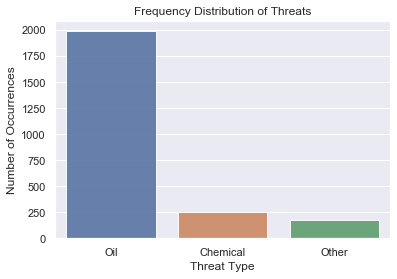

In [41]:
threat_count = oilspills['threat'].value_counts()

sns.barplot(threat_count.index, threat_count.values, alpha=0.9)

plt.title('Frequency Distribution of Threats')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Threat Type', fontsize=12)
plt.show()

Group by years and months to observe the changes over time

In [45]:
# add year and month columns
oilspills['year'] = pd.DatetimeIndex(oilspills['open_date']).year
oilspills['month'] = pd.DatetimeIndex(oilspills['open_date']).month

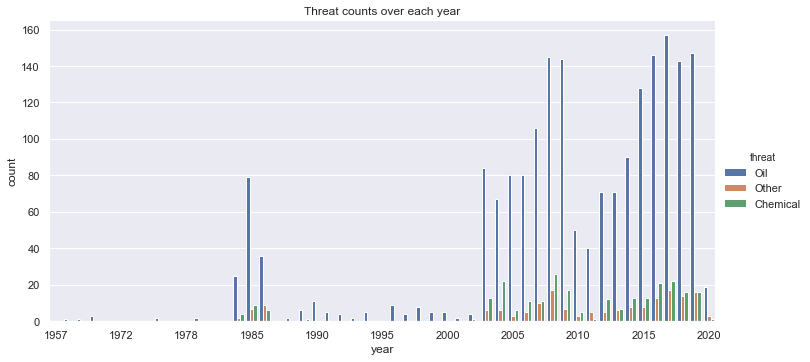

In [53]:
# plot by year
g = sns.catplot("year", 
                data=oilspills, 
                aspect=2,
                kind="count", 
                hue='threat')
g.set_xticklabels(step=5)

plt.title('Threat counts over each year')
plt.show()

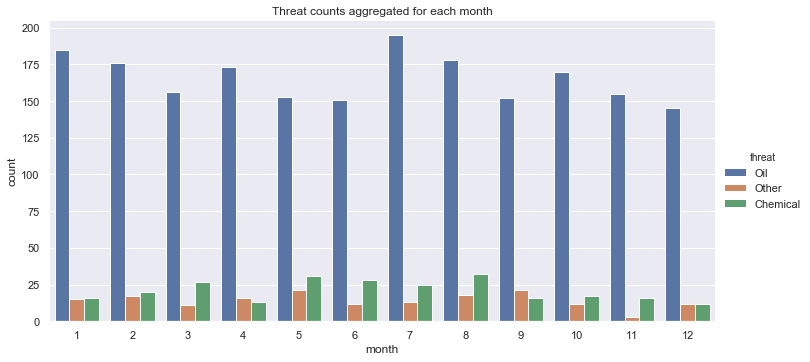

In [62]:
# plot by month
g = sns.catplot("month", 
                data=oilspills, 
                aspect=2,
                kind="count", 
                hue='threat')
g.set_xticklabels(step=1)

plt.title('Threat counts aggregated for each month')
plt.show()

Take a look at max_ptl_release_gallons and plot the counts and mean over each year. This could be interesting.

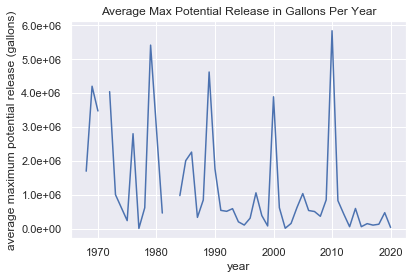

In [123]:
average_ptl_release_yearly = oilspills.groupby('year')['max_ptl_release_gallons'].mean()

fig, ax = plt.subplots()
ax.plot(average_ptl_release_yearly)

ax.set(xlabel='year', 
       ylabel='average maximum potential release (gallons)',
       title='Average Max Potential Release in Gallons Per Year')

ax.set_yticklabels(["{:.1e}".format(t) for t in ax.get_yticks()])

plt.show()

For the max potential oil spills, these appear to come in spikes. With four particular years standing out, these are 2010, 2000, 1989 and 1979 noticing a pattern of a major oil spill every 10 years. Quite worrying considering it has been 10 years since 2010.

In [127]:
oilspills.nlargest(5, 'max_ptl_release_gallons')

,open_date,name,location,lat,lon,threat,commodity,max_ptl_release_gallons,description,year,month
id,,,,,,,,,,,
8220,2010-04-21,Deepwater Horizon,Gulf of Mexico,28.7367,-88.3872,Oil,"Diesel, crude oil",205000000.0,NaN,2010,4
6694,1989-01-05,T/V SCURRY,"Detroit River Light, Lake Erie, Canada",42.3490,-82.9400,NaN,Carbon black feedstock,110000000.0,NaN,1989,1
6322,1986-05-01,Standard Chlorine of Delaware,"Delaware City, Delaware",39.5760,-75.5929,NaN,"Dichlorobenzene mother liquor, paradichloroben...",100000000.0,NaN,1986,5
7483,2000-07-04,MT Tuapse,Delaware Bay at Miah Maull Shoals,39.1167,-75.2000,NaN,Urea and ammonium nitrate (liquid fertilizers),88000000.0,NaN,2000,7
6282,1985-02-06,Georgia S.,"Amborse Channel, New York",40.5017,-73.9500,NaN,GYPSUM,51000000.0,NaN,1985,2


### Analysing Commodity

We use commodity over description as commodity is observed to have strings that are much more succint. Also, description has numerous mising entries so would not be as representative nor informative. Admittedly, we do not have enough domain knowledge in this area which could help with building visualisations as we would have a better idea of what to look out for or what pitfalls to avoid. Nevertheless, we will continue to build aiding visuals.

Findings from analysing the tokens in 'commodity':

-  Within the wordcloud, we observe the most popular words. Many as expected are related to oil and other chemical component. Interesting ones are 'louisiana', 'sweet'. Also the wordcloud helps us build a more complete image of what we are dealing with. We can quantify the number of the top 20 tokens with the barplot below.
-  From the most popular tokens' plot, we note, 6 occurs quite often, as well as unknown in the word counts. These could be indicative of something else.

Future Processing could involve:
-  Remove frequent words that do not provide much meaning, such as 'and', as well as punctuation (taking lessons from NLP text processing techniques).
-  Fill in NaN threat features if commody contains a particular token. For example, if commodity had the token oil, then we can assume the threat is of nature Oil.

In [171]:
def tokenise_strings(string_list) -> List[str]:
    
    tokens = []
    for string in string_list:
    
        if not isinstance(string, str):
            continue
        
        string_tokens = string.lower().split()
        string_tokens = [tkn.strip() for tkn in string_tokens]
        tokens.extend(string_tokens)
        
    return tokens

In [172]:
commodity_tokens = tokenise_strings(oilspills['commodity'])
commodity_tokens[:5]

['diesel', 'fuel', 'aviation', 'fuel', 'sulfuric']

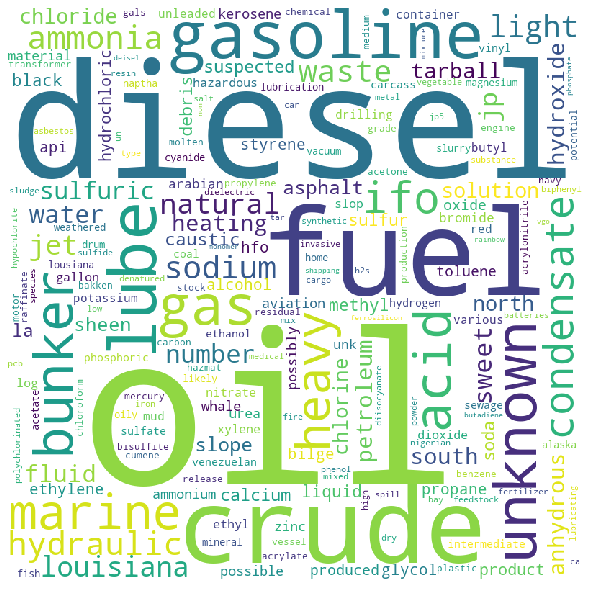

In [177]:
joined_tokens = (" ").join(commodity_tokens)

wordcloud = WordCloud(
    width = 800, 
    height = 800, 
    background_color ='white',
    collocations=False,
    stopwords = set(STOPWORDS), 
    min_font_size = 10).generate(joined_tokens) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In total there are 1322 unique tokens.


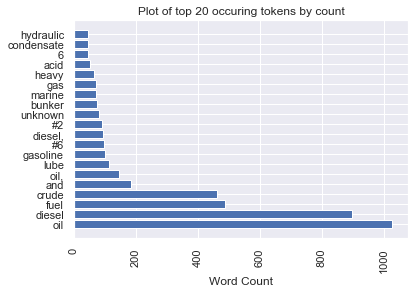

In [180]:
unique_tokens, unique_token_counts = np.unique(commodity_tokens, return_counts=True)

print(f"In total there are {len(unique_tokens)} unique tokens.")

plot_limit = 20
unique_tokens = [x for _,x in sorted(zip(unique_token_counts,unique_tokens))][::-1]
unique_token_counts = sorted(unique_token_counts)[::-1]

plt.barh(unique_tokens[:plot_limit], unique_token_counts[:plot_limit])
plt.xticks(rotation=90)
plt.xlabel("Word Count")
plt.title(f"Plot of top {plot_limit} occuring tokens by count")
plt.show()

Using commodity, we will apply Named Entity Recognition (NER) to see if we can engineer additional features. To do so, we will use SpaCy library. This could also be done for the description if it was available to add additional insights. We will categorise all extracted entities as 'key tokens' for the purpose of simplicity right now.

In [189]:
# uncomment below to download 
# !python3 -m spacy download en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()

In [199]:
oilspills['commodity'].values

array([nan, nan, nan, ..., 'Venezuelan crude oil, diesel fuel',
       'Venezuelan light crude oil',
       'diesel oil - approx. 80% heavy distillate, 20% residual fuel oil'],
      dtype=object)

In [202]:
sample_commodity = oilspills['commodity'].values[1000]

doc = nlp('European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices')
pprint([(X.text, X.label_) for X in doc.ents])

/Users/steven/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  "__main__", mod_spec)
/Users/steven/opt/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...



127.0.0.1 - - [30/May/2020 09:42:16] "GET / HTTP/1.1" 200 446
127.0.0.1 - - [30/May/2020 09:42:17] "GET /favicon.ico HTTP/1.1" 200 446


Shutting down server on port 5000.
